### Load libraries

In [1]:
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import linear_probe

### Load data

In [2]:
def get_cifar_data() -> tuple[np.ndarray, np.ndarray]:
    # Check if file exists:
    if (GIT_ROOT / "data/clip-embeddings/cifar10_clip.npz").exists():
        d = np.load(GIT_ROOT / "data/clip-embeddings/cifar10_clip.npz")
    else:
        d = np.load("/home/gridsan/groups/ccg/data/scaling/clip-embeddings/cifar10_clip.npz")

    xs_train, ys_train = d["xs_train"], d["ys_train"]
    xs_test, ys_test = d["xs_test"], d["ys_test"]

    xs, ys = np.concatenate([xs_train, xs_test]), np.concatenate([ys_train, ys_test])
    return xs, ys

CIFAR_XS, CIFAR_YS = get_cifar_data()

In [3]:
# Fit a GMM to the CIFAR-10 data

def fit_gmm(xs: np.ndarray, n_components: int) -> GaussianMixture:
    gmm = GaussianMixture(n_components=n_components, n_init=1)
    gmm.fit(xs)
    return gmm

def fit_gmms(xs: np.ndarray, ys: np.ndarray, n_components: int) -> list[GaussianMixture]:
    gmms = []
    for i in range(10):
        gmm = fit_gmm(xs[ys == i], n_components)
        gmms.append(gmm)
    return gmms

GMMS = fit_gmms(CIFAR_XS, CIFAR_YS, 1)

In [4]:
# Generate a bunch of samples from the GMMs (vectorized)
YS = np.random.choice(10, size=60000)
XS = np.zeros((60000, CIFAR_XS.shape[-1]))
for i in range(10):
    xs = GMMS[i].sample((YS == i).sum())[0]
    XS[YS == i] = xs

XS_TRAIN, YS_TRAIN = XS[:50000], YS[:50000]
XS_TEST, YS_TEST = XS[50000:], YS[50000:]
print(XS_TRAIN.shape, YS_TRAIN.shape, XS_TEST.shape, YS_TEST.shape)

DS = linear_probe.Dataset(XS_TRAIN, YS_TRAIN, XS_TEST, YS_TEST)

(50000, 768) (50000,) (10000, 768) (10000,)


### Collect scaling data

In [5]:
DATA = []

In [6]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01, 1, 100]:
        for seed in range(10):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    linear_probe.run_experiment(
                        ds=DS,
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: div

In [7]:
for n_train in tqdm([5000, 10000, 50000]):
    for C in [0.01]:
        for seed in range(1):
            for n_classes in [2, 5, 10]:
                with np.errstate(divide='ignore'):
                    DATA.append(
                        linear_probe.run_experiment(
                            ds=DS,
                            n_train=n_train,
                            n_classes=n_classes,
                            C=C,
                            max_iter=10000,
                            seed=seed,
                        )
                    )

  0%|          | 0/3 [00:00<?, ?it/s]

# Analyze data

In [9]:
df = pd.DataFrame(DATA)
df["err"] = 1 - df.acc

# Load original data
df_orig = pd.read_csv("clip-cifar-scaling.csv")
df

,n_classes,C,max_iter,seed,n_train,acc,xent,err
0,2,0.01,10000,0,1,0.521245,inf,0.478755
1,5,0.01,10000,0,1,0.208119,inf,0.791881
2,10,0.01,10000,0,1,0.098400,inf,0.901600
3,2,0.01,10000,1,1,0.478755,inf,0.521245
4,5,0.01,10000,1,1,0.192277,inf,0.807723
...,...,...,...,...,...,...,...,...
1804,5,0.01,10000,0,10000,1.000000,-0.000000,0.000000
1805,10,0.01,10000,0,10000,0.998000,0.005733,0.002000
1806,2,0.01,10000,0,9927,1.000000,-0.000000,0.000000
1807,5,0.01,10000,0,24806,1.000000,0.000023,0.000000


In [13]:
# df.to_csv("clip-cifar-gmm-scaling.csv", index=False)

### CLIP scaling

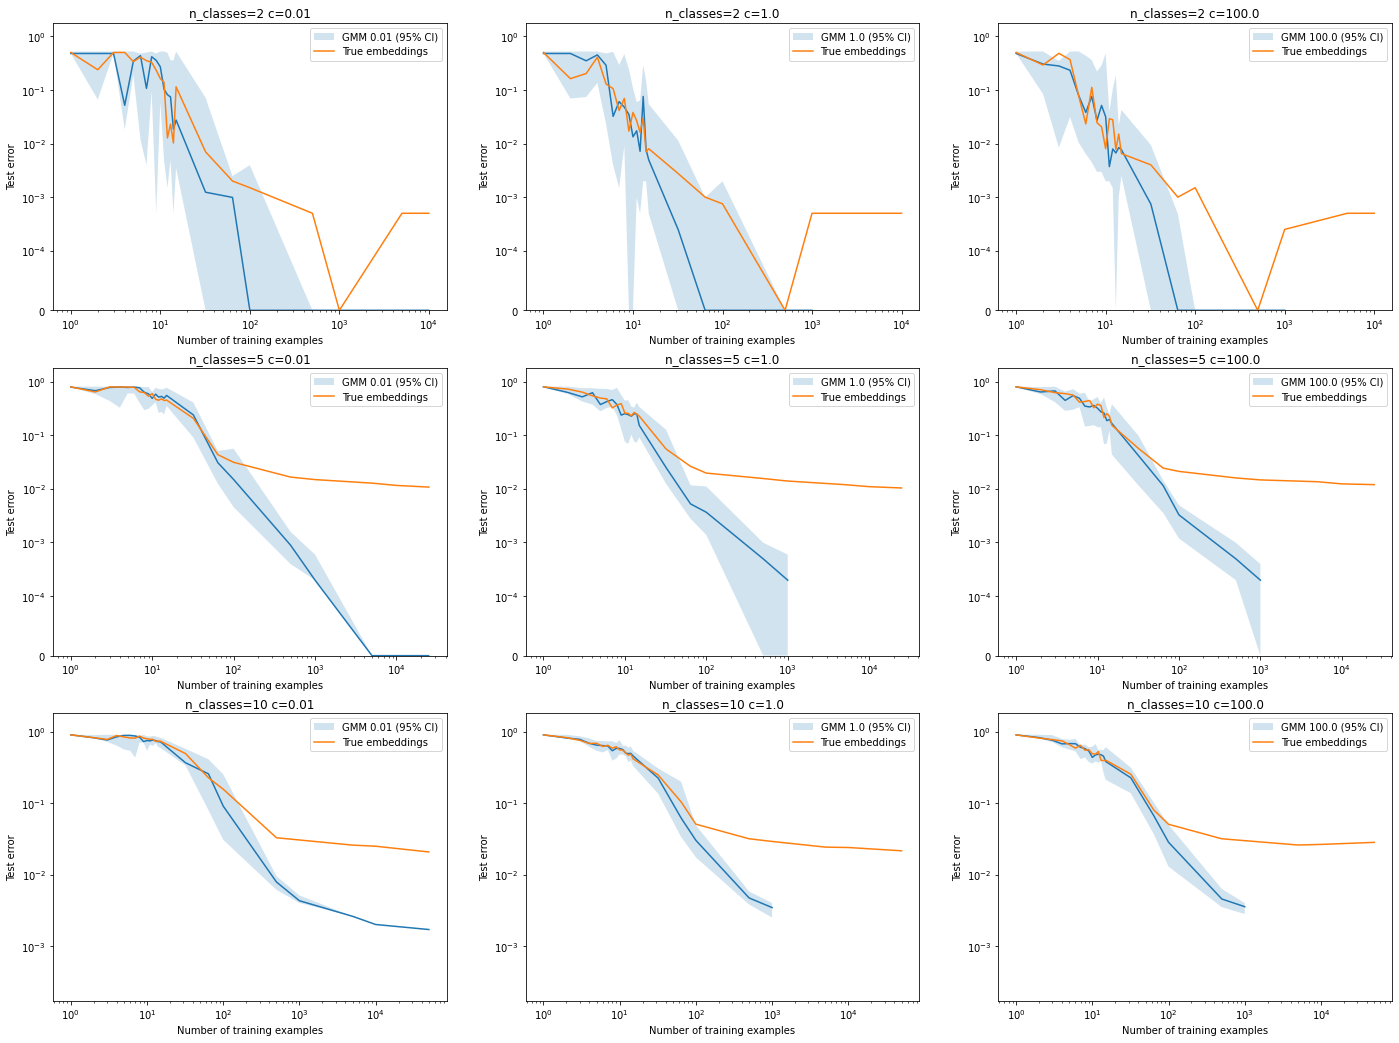

In [11]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"GMM {c} (95% CI)"
        )

        gbo = df_orig.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        mid = gbo.median()
        plt.plot(mid.index, mid, label="True embeddings")

        plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").err.min(), 2 * df.err.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test error")

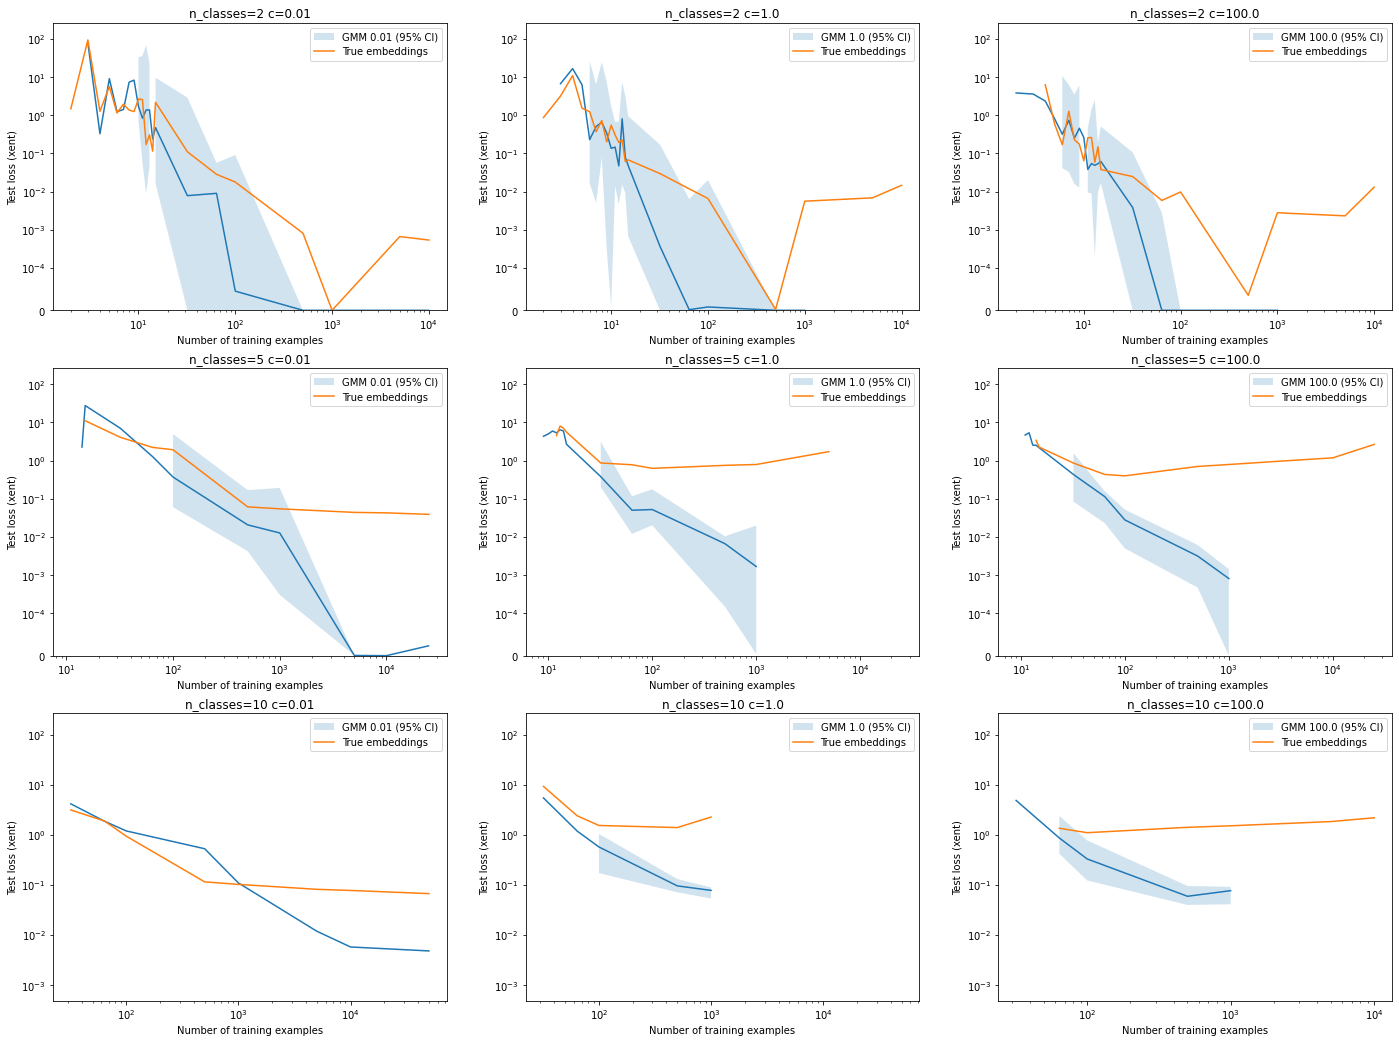

In [12]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"GMM {c} (95% CI)"
        )

        gbo = df_orig.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        mid = gbo.median()
        plt.plot(mid.index, mid, label="True embeddings")

        with pd.option_context('mode.use_inf_as_na', True):
            plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").xent.min(), 2 * df.dropna().xent.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test loss (xent)")

One thing to note about the above plots: The last three points are only single samples and do not have error bars!